# Tennis Shoes Analysis

## Loading Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#NLP Packages
import nltk
nltk.download('punkt')
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

pd.set_option('max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Establishing the brand webpages to scrape from

In [2]:
headers = {
    'User-Agent': 'https://developers.whatismybrowser.com/useragents/parse/1252728chrome-windows-blink' 
}

brand_urls = ['https://www.tennis-warehouse.com/Nike_Tennis_Shoes/catpage-MSNIKE.html',
              'https://www.tennis-warehouse.com/adidas_Mens_Tennis_Shoes/catpage-MSADIDAS.html',
              'https://www.tennis-warehouse.com/Asics_Mens_Tennis_Shoes/catpage-MSASICS.html',
              'https://www.tennis-warehouse.com/Babolat_Mens_Tennis_Shoes/catpage-MSBAB.html',
              'https://www.tennis-warehouse.com/New_Balance_Mens_Tennis_Shoes/catpage-MSNEWBAL.html']

Within the brand urls, I scrape the urls for each shoe group within the brands. 

In [3]:
group_urls = []
for url in brand_urls:

    page = requests.get(url, headers = headers).text
    soup=BeautifulSoup(page,'html.parser')
    shoe_group = soup.find_all('a',{'class':'ga_event', 'data-trackcategory':'Profiler'})
    for group in shoe_group:
        group_url = group.get('href')
        group_url = 'https://www.tennis-warehouse.com'+str(group_url)
        group_urls.append(group_url)

In [4]:
group_urls = [x for x in group_urls if '2E' not in x 
             and '4E' not in x and 'D_Width' not in x]

### Creating a Shoe URL Dataframe
Using the shoe group urls above, I will scrape the individual urls for each shoe within the shoe groups

In [5]:
data = []
for group_url in group_urls:
    
    page = requests.get(group_url, headers = headers).text
    soup=BeautifulSoup(page,'html.parser')
    
    title_info = soup.find('header', {'class':'catheader'})
    title = title_info.text

    shoe_list = soup.find_all('a' ,{'class':"cattable-wrap-cell-info"})
    for shoe in shoe_list:
        shoe_url = shoe.get('href')
        
        shoe_dict = {'Shoe Group': title, 'Product Link': shoe_url}
        data.append(shoe_dict)

In [6]:
shoe_df = pd.DataFrame(data)
shoe_df.tail()

,Shoe Group,Product Link
95,New Balance MC 1006 Men's Tennis Shoes,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Black_Silver/descpageMSNB-M106BS4.html
96,New Balance MC 1006 Men's Tennis Shoes,https://www.tennis-warehouse.com/New_Balance_MC_1006_D_Wh_Navy/descpageMSNB-M106WND.html
97,New Balance MC 1006 Men's Tennis Shoes,https://www.tennis-warehouse.com/New_Balance_MC_1006_2E_Wh_Navy/descpageMSNB-M106WN2.html
98,New Balance MC 1006 Men's Tennis Shoes,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Wh_Navy/descpageMSNB-M106WN4.html
99,New Balance MC 806 Men's Tennis Shoes,https://www.tennis-warehouse.com/New_Balance_MC_806_W_D/descpageMSNB-MC806WD.html


In [7]:
shoe_df['Shoe Group'] = shoe_df['Shoe Group'].str.replace('Men\'s Tennis Shoes','')

In [8]:
shoe_df = shoe_df[shoe_df['Product Link'].str.contains('tennis')]

In [9]:
product_urls = shoe_df['Product Link'].tolist()

### Creating a Shoe Price Dataframe
Using the product urls created above to retrieve the shoe name, price, rating, and # of reviews.

In [10]:
data = []
for product in product_urls:
    response = requests.get(product, headers = headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    

    title = soup.find('h1' ,{'class':'h2 desc_top-head-title', 'itemprop':'name'})
    name = title.string
    
    price_info = soup.find('span', {'class':'afterpay-full_price'})
    price = price_info.text

    try:
        rating_info = soup.find('div',{'class':'review_agg'})
        rating = rating_info.text
    except:
        rating = np.nan
    
    try:
        review_info = soup.find('a',{'id':'no-select'})
        review_num = review_info.text
    except:
        review_num = np.nan
    
    shoe_dict = {'Shoe': name, 'Price': price, 'Rating': rating, 'Reviews': review_num, 'Product Link': product}
    data.append(shoe_dict)

In [11]:
shoe_price = pd.DataFrame(data)
shoe_price.tail()

,Shoe,Price,Rating,Reviews,Product Link
93,New Balance MC 1006 4E Black/Silver,119.95,4.0,2 Reviews,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Black_Silver/descpageMSNB-M106BS4.html
94,New Balance MC 1006 D Wh/Navy,119.95,4.0,2 Reviews,https://www.tennis-warehouse.com/New_Balance_MC_1006_D_Wh_Navy/descpageMSNB-M106WND.html
95,New Balance MC 1006 2E Wh/Navy,119.95,4.0,2 Reviews,https://www.tennis-warehouse.com/New_Balance_MC_1006_2E_Wh_Navy/descpageMSNB-M106WN2.html
96,New Balance MC 1006 4E Wh/Navy,119.95,4.0,2 Reviews,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Wh_Navy/descpageMSNB-M106WN4.html
97,New Balance MC 806 W D,119.95,5.0,Submit a Review,https://www.tennis-warehouse.com/New_Balance_MC_806_W_D/descpageMSNB-MC806WD.html


In [12]:
shoe_price['Brand'] = shoe_price['Shoe'].str.split(' ').str[0]
shoe_price['Brand'].value_counts()

Nike         28
Babolat      18
adidas       16
New          14
NikeCourt    13
Asics         9
Name: Brand, dtype: int64

In [13]:
shoe_price['Brand'] = shoe_price['Brand'].str.replace('NikeCourt','Nike').str.replace('New','New Balance')

### Which shoes are on average the most expensive?

In [14]:
shoe_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Shoe          98 non-null     object
 1   Price         98 non-null     object
 2   Rating        97 non-null     object
 3   Reviews       98 non-null     object
 4   Product Link  98 non-null     object
 5   Brand         98 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [16]:
shoe_price['Price'] = shoe_price['Price'].apply(pd.to_numeric, errors = 'ignore')
avg_price = pd.DataFrame(shoe_price.groupby('Brand')['Price'].mean().reset_index().sort_values(by='Price', ascending=False))
avg_price

,Brand,Price
2,New Balance,132.817857
0,Asics,131.083333
3,Nike,112.524878
1,Babolat,112.483333
4,adidas,112.136250


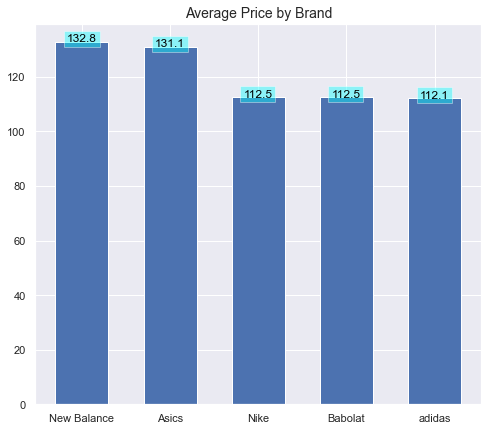

In [17]:
figure = plt.figure(figsize=(8,7))
plt.bar(avg_price['Brand'], avg_price['Price'], width=.6)
plt.title('Average Price by Brand', fontsize=14)
for i, v in enumerate(round(avg_price['Price'],1)):
    plt.text(i-.17, v, str(v), color = 'black', 
             Bbox = dict(facecolor = 'cyan', alpha =.4, pad = 3))
plt.show()

### Creating a Shoe Fit Dataframe
Creating a dataframe that contains the shoe's fit attributes (i.e. length, width, weight, etc) using the list of shoe urls.

In [18]:
dfs = []
for product in product_urls:
    response = requests.get(product, headers = headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    details = soup.find_all('div',{'class': 'desc_specs_wrap app_specs'})
    try:
        temp_df = pd.read_html(str(details))[0]
        temp_df['Link'] = product
        temp_df.columns = ['Category','Value', 'Product Link']
        temp_df['Category'] = temp_df['Category'].str.replace(':','')
        temp_df = temp_df.pivot(columns='Category', values = 'Value', index = 'Product Link').reset_index()
        dfs.append(temp_df)
    except:
        pass
    
fit_df = pd.concat(dfs, ignore_index=True)

In [19]:
fit_df.head()

Category,Product Link,Arch,Break-in,Length,Weight,Width,Court Type,Durability Guarantee,Durability Gurantee,Surface,Durability
0,https://www.tennis-warehouse.com/Nike_Air_Zoom_Vapor_Pro_Photo_Blue_Bone_Mens_Shoe/descpageMSNIKE-NMVPPBB.html,Slightly Low,Slight,True,12.9 ounces (size 10.5),Medium,NaN,NaN,NaN,NaN,NaN
1,https://www.tennis-warehouse.com/Nike_Air_Zoom_Vapor_Pro_Bk_Mint_White_Mens_Shoe/descpageMSNIKE-NMVPBMW.html,Slightly Low,Slight,True,12.9 ounces (size 10.5),Medium,NaN,NaN,NaN,NaN,NaN
2,https://www.tennis-warehouse.com/Nike_Air_Zoom_Vapor_Pro_White_Dynamic_Turq_Mens_Shoe/descpageMSNIKE-NMVPWD.html,Slightly Low,Slight,True,12.9 ounces (size 10.5),Medium,NaN,NaN,NaN,NaN,NaN
3,https://www.tennis-warehouse.com/Nike_Air_Zoom_Vapor_Pro_White_Slate_Grey_Mens_Shoe/descpageMSNIKE-NMVPWSG.html,Slightly Low,Slight,True,12.9 ounces (size 10.5),Medium,NaN,NaN,NaN,NaN,NaN
4,https://www.tennis-warehouse.com/Nike_Air_Zoom_Vapor_Pro_White_WashedTeal_Red_Mens_Shoe/descpageMSNIKE-NMVPWT.html,Slightly Low,Slight,True,12.9 ounces (size 10.5),Medium,NaN,NaN,NaN,NaN,NaN


In [20]:
fit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Product Link          96 non-null     object
 1   Arch                  96 non-null     object
 2   Break-in              96 non-null     object
 3   Length                96 non-null     object
 4   Weight                96 non-null     object
 5   Width                 96 non-null     object
 6   Court Type            10 non-null     object
 7   Durability Guarantee  14 non-null     object
 8   Durability Gurantee   3 non-null      object
 9   Surface               11 non-null     object
 10  Durability            4 non-null      object
dtypes: object(11)
memory usage: 8.4+ KB


### Creating the Shoe Description Dataframe
Scraping the shoe descriptions will give us text that we can use to decipher whether the shoe offers a 6 month durability guarantee.

In [21]:
data = []
for product in product_urls:
    response = requests.get(product, headers = headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    desc_info = soup.find('div', {'class': 'check_read-inner', 'itemprop':'description'})
    description = desc_info.text
    
    desc_dict = {'Product Link': product, 'Description': description}
    data.append(desc_dict)

In [22]:
description_df = pd.DataFrame(data)
description_df.tail()

,Product Link,Description
93,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Black_Silver/descpageMSNB-M106BS4.html,"The MC 1006 is a great choice for the avid tennis competitor who craves comfort on court. The thick REVlite midsole offers loads of plush cushioning and support that you'll feel and appreciate under your feet during long matches. The lightweight synthetic upper has plenty of mesh to provide exceptional ventilation, keeping your feet cool even on the hottest of days. The unique tread pattern on the outsole is designed to offer excellent traction and durability on any court surface. Treat your feet with this comfortable performance offering from New Balance! Upper: Synthetic materials with lots of mesh provide lightweight support and breathability. The Long Wear Drag Tip provides extra durability in the toe area.\rMidsole: REVlite EVA midsole offers loads of cushioning and support under foot. \rOutsole: Non-marking NDurance rubber outsole in a modified herringbone tread pattern lends itself to good traction and durability on any court surface. Backed by a six month durability guarantee.\rColor: Black / Silver\r Fit Details Length: True Width: Extra Wide (4E) Arch: Low Break-in: None Weight: 14.8 ounces (size 10.5)"
94,https://www.tennis-warehouse.com/New_Balance_MC_1006_D_Wh_Navy/descpageMSNB-M106WND.html,"The MC 1006 is a great choice for the avid tennis competitor who craves comfort on court. The thick REVlite midsole offers loads of plush cushioning and support that you'll feel and appreciate under your feet during long matches. The lightweight synthetic upper has plenty of mesh to provide exceptional ventilation, keeping your feet cool even on the hottest of days. The unique tread pattern on the outsole is designed to offer excellent traction and durability on any court surface. Treat your feet with this comfortable performance offering from New Balance! Upper: Synthetic materials with lots of mesh provide lightweight support and breathability. The Long Wear Drag Tip provides extra durability in the toe area.\rMidsole: REVlite EVA midsole offers loads of cushioning and support under foot. \rOutsole: Non-marking NDurance rubber outsole in a modified herringbone tread pattern lends itself to good traction and durability on any court surface. Backed by a six month durability guarantee.\rColor: White / Navy Blue\r Fit Details Length: True Width: Medium (D) Arch: Low Break-in: None Weight: 14.8 ounces (size 10.5)"
95,https://www.tennis-warehouse.com/New_Balance_MC_1006_2E_Wh_Navy/descpageMSNB-M106WN2.html,"The MC 1006 is a great choice for the avid tennis competitor who craves comfort on court. The thick REVlite midsole offers loads of plush cushioning and support that you'll feel and appreciate under your feet during long matches. The lightweight synthetic upper has plenty of mesh to provide exceptional ventilation, keeping your feet cool even on the hottest of days. The unique tread pattern on the outsole is designed to offer excellent traction and durability on any court surface. Treat your feet with this comfortable performance offering from New Balance! Upper: Synthetic materials with lots of mesh provide lightweight support and breathability. The Long Wear Drag Tip provides extra durability in the toe area.\rMidsole: REVlite EVA midsole offers loads of cushioning and support under foot. \rOutsole: Non-marking NDurance rubber outsole in a modified herringbone tread pattern lends itself to good traction and durability on any court surface. Backed by a six month durability guarantee.\rColor: White / Navy Blue\r Fit Details Length: True Width: Wide (2E) Arch: Low Break-in: None Weight: 14.8 ounces (size 10.5)"
96,https://www.tennis-warehouse.com/New_Balance_MC_1006_4E_Wh_Navy/descpageMSNB-M106WN4.html,"The MC 1006 is a great choice for the avid tennis competitor who craves comfort on court. The thick REVlite midsole offers loads of plush cushioning and support that you'll feel and appreciate under your fe

In [23]:
description_df['Warranty'] = description_df['Description'].str.contains('durability guarantee')

### Combining Dataframes

In [24]:
shoe_df = pd.merge(shoe_df, shoe_price, on = 'Product Link', how = 'left')

In [25]:
shoe_df = pd.merge(shoe_df, fit_df, on = 'Product Link', how = 'left')

In [26]:
shoe_df = pd.merge(shoe_df, description_df, on = 'Product Link', how = 'left')

In [27]:
shoe_df.drop(['Durability Guarantee', 'Durability Gurantee'],axis=1,inplace=True)

## Data Cleaning

### Shoe Break In

In [28]:
shoe_df['Break-in'].value_counts(dropna=False)

None                      46
Slight                    15
No                        13
Some break-in required     7
Yes                        5
None required              5
None Required              3
NaN                        2
xx                         1
No break-in                1
Name: Break-in, dtype: int64

In [29]:
shoe_df['Break-in'] = np.where(shoe_df['Break-in'].str.contains('Slight|Some|Yes'), 'Yes', 'No')

### Arch

In [30]:
shoe_df['Arch'].value_counts()

Medium          38
Slightly Low    24
Low             14
Slightly low    13
Normal           4
Medium-High      2
xx               1
Name: Arch, dtype: int64

In [31]:
shoe_df['Arch'] = shoe_df['Arch'].str.replace('xx|Medium-High','Medium').str.replace('Slightly [Ll]ow','Low')

### Length

In [32]:
shoe_df['Length'].value_counts()

True                                                                           67
Long, we recommend going a half size down.                                      7
Slightly Snug                                                                   4
Slightly Short (if you are in between sizes go with the larger of the two)      4
True to size                                                                    3
True (if between sizes, we recommend going to the smaller size)                 3
Toe-box is shallow, for a comfortable fitwe recommend going a half size up.     2
Snug                                                                            2
Generous                                                                        1
xx                                                                              1
True�                                                                           1
Short (We recommend going a half size up)                                       1
Name: Length, dt

In [33]:
shoe_df['Length'] = np.where(shoe_df['Length'].str.contains('xx|True'), 'True', shoe_df['Length'])
shoe_df['Length'] = np.where(shoe_df['Length'].str.contains('shallow'), 'Snug', shoe_df['Length'])
shoe_df['Length'] = np.where(shoe_df['Length'].str.contains('Long|Generous'), 'Long', shoe_df['Length'])

### Width

In [34]:
shoe_df['Width'].value_counts(dropna=False)

Medium                                                   52
Snug Medium                                              11
Medium (snug in the middle/arch region)                   6
Narrow                                                    5
Wide (2E)                                                 4
Medium (we find it slightly narrower than the Uber 3)     3
Slightly Wide (mostly in the toe-box)                     3
Medium (D)                                                3
NaN                                                       2
Slightly Wide in the Forefoot                             2
2E Wide                                                   2
Extra Wide (4E)                                           2
xx                                                        1
Snug through heel and midfoot                             1
Medium / Slightly Narrow in forefoot                      1
Name: Width, dtype: int64

### Weight

In [35]:
shoe_df['Weight'].value_counts()

12.9 ounces (size 10.5)       13
12.4 ounces (size 10.5)        8
15.8 ounces (size 10.5)        7
15.1 ounces (size 10.5)        7
14.2 ounces (size 10.5)        7
14.8 ounces (size 10.5)        6
14.5 ounces (size 10.5)        6
13.2 ounces (size 10.5)        4
14.3 ounces (size 10.5)        4
12.9 ounces (US size 10.5)     4
13.4 ounces (size 10.5)        4
12.1 ounces (size 10.5)        4
14.7 ounces (size 10.5)        3
13.9 ounces (size 10.5)        3
13.5 ounces (size 10.5)        3
16.2 ounces (size 10.5)        2
15.7 ounces (size 10.5)        2
12.6 ounces (size 10.5)        2
15.4 ounces (size 10.5)        1
14.7 ounces (US size 10.5)     1
11.7 ounces (size 10.5)        1
13.8 ounces (size 10.5)        1
TBD ounces (size 10.5)         1
15.6 ounces (size 10.5)        1
15.5 ounces (size 10.5)        1
Name: Weight, dtype: int64

In [36]:
shoe_df['Weight'] = shoe_df['Weight'].str.split(' ').str[0]

### Reviews

In [37]:
shoe_df['Reviews'].value_counts()

6 Reviews          15
2 Reviews          15
7 Reviews          12
4 Reviews          12
18 Reviews          8
10 Reviews          8
8 Reviews           6
29 Reviews          4
17 Reviews          4
13 Reviews          4
1 Review            3
12 Reviews          3
5 Reviews           2
Submit a Review     2
Name: Reviews, dtype: int64

In [38]:
shoe_df['Reviews'] = shoe_df['Reviews'].str.replace('Submit a Review', '0')
shoe_df['Reviews'] = shoe_df['Reviews'].str.split(' ').str[0]

In [39]:
shoe_df['Reviews'] = shoe_df['Reviews'].apply(pd.to_numeric)

### Rating

In [40]:
shoe_df['Rating'].value_counts()

3.8    16
3.0    11
5.0    10
3.3     8
3.5     8
4.8     7
1.2     6
4.0     6
2.8     5
4.6     4
1.5     3
4.3     3
3.1     3
4.1     2
4.4     2
3.4     2
3.6     1
Name: Rating, dtype: int64

In [41]:
shoe_df['Rating'] = shoe_df['Rating'].str.strip()
shoe_df['Rating'] = shoe_df['Rating'].apply(pd.to_numeric)

## Creating the Shoe Review Dataframe
For each unique shoe (some shoes are duplicate shoes with different urls for different colors), I will scrape the customer reviews for the shoe, along with the review titles and the stars given.

In [42]:
cols = shoe_df.columns
shoe_df[cols] = shoe_df.apply(pd.to_numeric, errors='ignore')

In [43]:
unique_shoe = shoe_df.copy()

In [44]:
unique_shoe = unique_shoe[['Shoe Group','Product Link', 'Shoe']]
unique_shoe = unique_shoe.sort_values(by='Shoe')

Each shoe has multiple urls for each color option, with each url having the same reviews. Removing all the duplicate shoes so we have less reviews to scrape.

In [45]:
unique_shoe.drop_duplicates(subset=['Shoe Group'], keep='first', inplace=True)

In [46]:
unique_urls = unique_shoe['Product Link'].to_list()

In [47]:
data = []
for url in unique_urls:
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    review_info = soup.find_all('div',{'itemprop':'review','class':'single-review-container'})
    for item in review_info:
        name_info = item.find('span',{'itemprop':'name','class':'review-title'})
        name = name_info.text
        
        stars_info = item.find('span',{'itemprop':'ratingValue', 'class':'single-rating-value'})
        stars = stars_info.text
        
        body_info = item.find('span',{'itemprop':'reviewBody','class':'review-body'})
        body = body_info.text
        
        title_dict = {'Link': url, 'Title': name, 'Stars': stars, 'Review': body}
        data.append(title_dict)

In [48]:
review_df = pd.DataFrame(data)
review_df.head(5)

,Link,Title,Stars,Review
0,https://www.tennis-warehouse.com/Asics_Court_FF_2_Black_Green_Gecko_Mens_Shoes/descpageMSASICS-AMCFFBG.html,My favorite tennis shoes,5,"I've been trying a few shoes lately (FF Court, new Barricade, and Nike Zoom Cage) and the FFs have been my favorite so far. I pair my shoes with an Aryse ankle brace, and the FF's have been the best at handling my brace in the arch area (although a bit tough to get in at first).\n\nI would say break-in time was minimal - maybe a set or less. \n\nThe only negative as everyone has mentioned are the laces. But that's easy to fix."
1,https://www.tennis-warehouse.com/Asics_Gel_Challenger_13_White_Black_Mens_Shoes/descpageMSASICS-AMCH3WB.html,Amazing shoe,5,"Very comfortable, amazing shoes!"
2,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,ASICS 2E resolution,1,Not very wide. Still feels narrow by the ankle and heel. Didn't even dare play with them on.
3,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,Asics Shoes,5,"This is the second time that I have bought Asics. These are very comfortable, more-so than the Speed FF. The cushioning feels very good. I hope they last a long time."
4,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,Amazing Shoe,5,"Great fit, comfortable and stable!"


### Visualizing the Distribution of Reviews by Stars

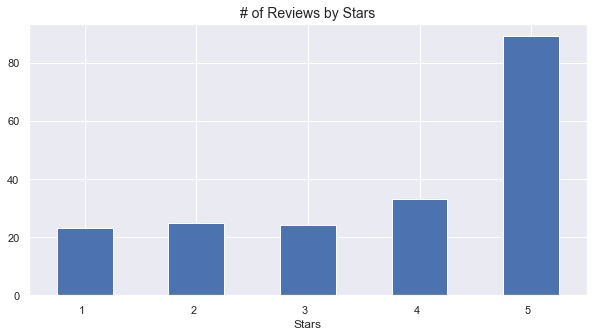

In [49]:
ax = review_df['Stars'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
ax.set_xlabel('Stars')
ax.set_xticklabels(labels = [1,2,3,4,5], rotation = 0, ha='right')
ax.set_title('# of Reviews by Stars', fontsize=14)
plt.show()

### Which brands have the highest average rating?

In [50]:
review_df['Stars'] = review_df['Stars'].astype(int)

In [51]:
review_df = pd.merge(review_df, shoe_df[['Brand','Product Link']], how='left', left_on='Link', right_on='Product Link')

In [52]:
brand_stars = pd.DataFrame(review_df.groupby('Brand')['Stars'].mean().round(2).reset_index().sort_values(by='Stars'))

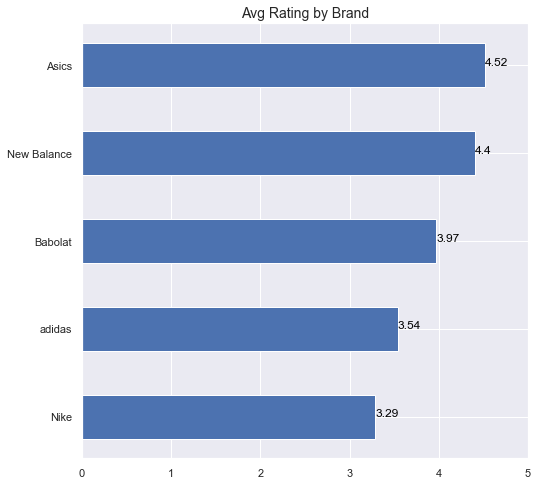

In [53]:
fig = plt.figure(figsize=(8,8))
plt.barh(brand_stars['Brand'], brand_stars['Stars'], height = .5)
for i, v in enumerate(brand_stars['Stars']):
    plt.text(v, i, str(v), color = 'black')
    plt.xlim([0,5])
plt.title('Avg Rating by Brand', fontsize=14)
plt.show()

### Comparing the Average Rating vs the Number of Reviews

In [54]:
review_stars = pd.DataFrame(review_df.groupby('Brand')['Stars','Review'].agg({'Stars':'mean','Review':'count'}).reset_index())
review_stars['Stars'] = review_stars['Stars'].round(2)

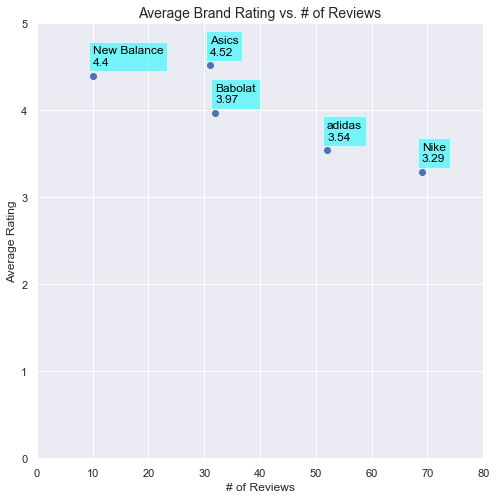

In [55]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data=review_stars, x = 'Review', y = 'Stars')

for i in range(review_stars.shape[0]):
    plt.text(x=review_stars.Review[i],y=review_stars.Stars[i]+0.12,s=str(review_stars.Brand[i]) + "\n" +
            str(review_stars.Stars[i]), 
          fontdict=dict(color='black',size=12),
          bbox=dict(facecolor='cyan',alpha=0.5))
plt.xlabel('# of Reviews')
plt.ylabel('Average Rating')
plt.title('Average Brand Rating vs. # of Reviews', fontsize=14)
plt.xlim([0,80])
plt.ylim([0,5])
plt.show()

In [56]:
review_df = review_df.reset_index()

## Natural Language Processing

### RoBERTa Transformer Model
See the link below for more info on this pretrained model.

https://huggingface.co/docs/transformers/model_doc/roberta

In [57]:
# Loading the pre-trained model
model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

In [58]:
def polarity_scores_roberta(example):    
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'neg': scores[0],
        'neu': scores[1],
        'pos': scores[2]
    }
    return(scores_dict)

In [59]:
res = {}
for i, row in tqdm(review_df.iterrows(), total = len(review_df)):
    text = row['Review']
    rowid = row['index']
    
    roberta_result = polarity_scores_roberta(text)
    res[rowid] = roberta_result

  0%|          | 0/194 [00:00<?, ?it/s]

In [60]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index()
results_df = results_df.merge(review_df, how = 'left')

In [61]:
results_df.head()

,index,neg,neu,pos,Link,Title,Stars,Review,Brand,Product Link
0,0,0.010497,0.116675,0.872828,https://www.tennis-warehouse.com/Asics_Court_FF_2_Black_Green_Gecko_Mens_Shoes/descpageMSASICS-AMCFFBG.html,My favorite tennis shoes,5,"I've been trying a few shoes lately (FF Court, new Barricade, and Nike Zoom Cage) and the FFs have been my favorite so far. I pair my shoes with an Aryse ankle brace, and the FF's have been the best at handling my brace in the arch area (although a bit tough to get in at first).\n\nI would say break-in time was minimal - maybe a set or less. \n\nThe only negative as everyone has mentioned are the laces. But that's easy to fix.",Asics,https://www.tennis-warehouse.com/Asics_Court_FF_2_Black_Green_Gecko_Mens_Shoes/descpageMSASICS-AMCFFBG.html
1,1,0.001531,0.015846,0.982623,https://www.tennis-warehouse.com/Asics_Gel_Challenger_13_White_Black_Mens_Shoes/descpageMSASICS-AMCH3WB.html,Amazing shoe,5,"Very comfortable, amazing shoes!",Asics,https://www.tennis-warehouse.com/Asics_Gel_Challenger_13_White_Black_Mens_Shoes/descpageMSASICS-AMCH3WB.html
2,2,0.779032,0.209068,0.011899,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,ASICS 2E resolution,1,Not very wide. Still feels narrow by the ankle and heel. Didn't even dare play with them on.,Asics,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html
3,3,0.001224,0.012281,0.986495,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,Asics Shoes,5,"This is the second time that I have bought Asics. These are very comfortable, more-so than the Speed FF. The cushioning feels very good. I hope they last a long time.",Asics,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html
4,4,0.001776,0.026636,0.971588,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html,Amazing Shoe,5,"Great fit, comfortable and stable!",Asics,https://www.tennis-warehouse.com/Asics_Gel_Resolution_8_2E_Blue_Harmony_Wh_Mens_Shoes/descpageMSASICS-AMG8EHW.html


In [62]:
def sentiment_label(df):
    if df['neg'] > df['pos'] and df['neg'] > df['neu']:
        return 'Negative'
    elif df['pos'] > df['neg'] and df['pos'] > df['neu']:
        return 'Positive'
    else:
        return 'Neutral'

In [63]:
results_df['Sentiment'] = results_df.apply(sentiment_label, axis = 1)

### What is the sentiment breakdown of the reviews?

In [64]:
sentiment_count = pd.DataFrame(results_df.groupby('Sentiment')['Review'].count().reset_index())

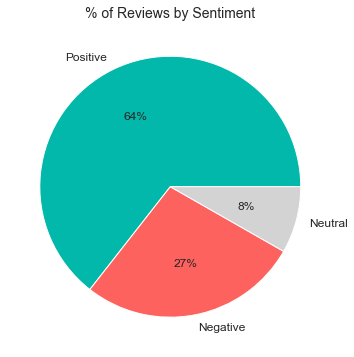

In [65]:
fig = plt.figure(figsize=(6,6))
results_df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['#01b8aa','#fd625e','lightgrey'], fontsize = 12)
plt.title('% of Reviews by Sentiment', fontsize=14)
plt.axis('off')
plt.show()

### Which brands have the most positive reviews? 

In [69]:
brand_pos = pd.DataFrame(results_df.groupby('Brand')['pos'].mean().reset_index().sort_values(by='pos', ascending=False))

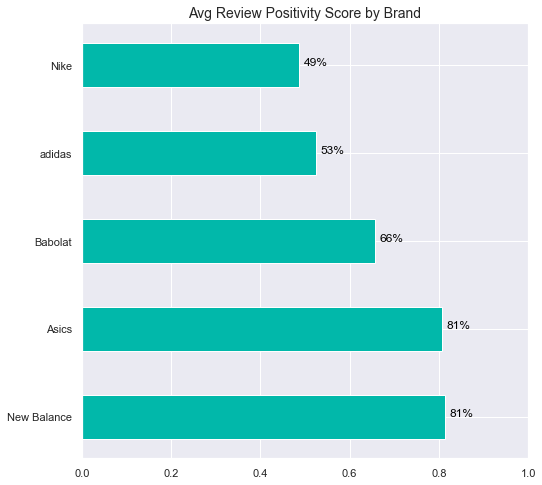

In [70]:
fig = plt.figure(figsize=(8,8))
plt.barh(brand_pos['Brand'], brand_pos['pos'], color = '#01b8aa', height = .5)
for i, v in enumerate(brand_pos['pos']):
    plt.text(v+.01, i, str(round(v*100))+str('%'), color = 'black')
plt.xlim([0,1])
plt.title('Avg Review Positivity Score by Brand', fontsize=14)
plt.show()

### Which brands have the most negative reviews?

In [71]:
brand_neg = pd.DataFrame(results_df.groupby('Brand')['neg'].mean().reset_index().sort_values(by='neg', ascending=False))

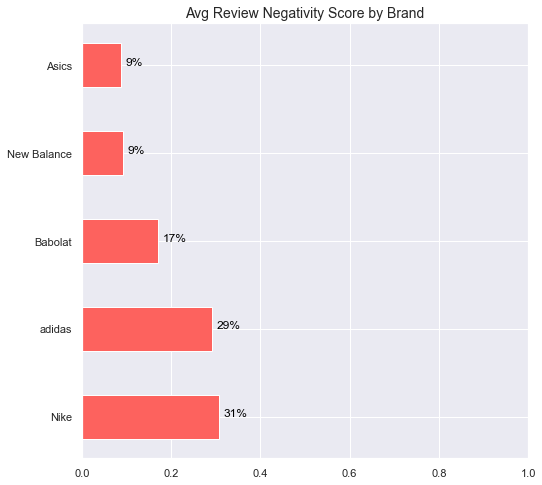

In [72]:
fig = plt.figure(figsize=(8,8))
plt.barh(brand_neg['Brand'], brand_neg['neg'], color = '#fd625e', height = .5)
for i, v in enumerate(brand_neg['neg']):
    plt.text(v+.01, i, str(round(v*100))+str('%'), color = 'black')
plt.xlim([0,1])
plt.title('Avg Review Negativity Score by Brand', fontsize=14)
plt.show()

### Comparing Positivity and Negativity Scores with Customer Ratings
Do the sentiment scores match up with the customer-given ratings?

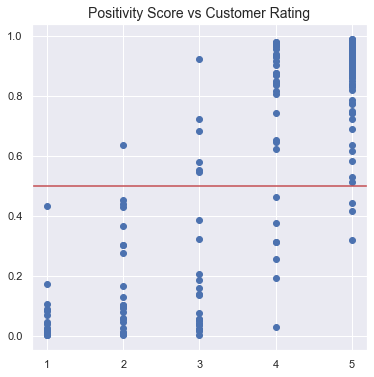

In [73]:
fig = plt.figure(figsize=(6,6))
plt.scatter(results_df['Stars'], results_df['pos'])
plt.xticks([1,2,3,4,5])
plt.axhline(0.5, color = 'r')
plt.title('Positivity Score vs Customer Rating', fontsize = 14)
plt.show()

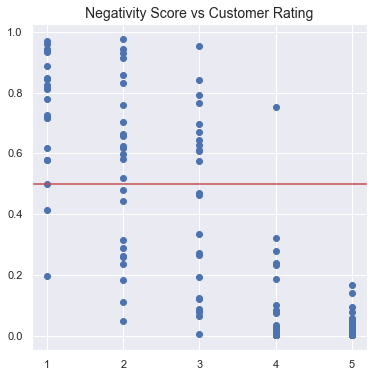

In [74]:
fig = plt.figure(figsize=(6,6))
plt.scatter(results_df['Stars'], results_df['neg'])
plt.xticks([1,2,3,4,5])
plt.axhline(0.5, color = 'r')
plt.title('Negativity Score vs Customer Rating', fontsize = 14)
plt.show()

In [75]:
#shoe_df.to_csv(r'Documents\Tennis Shoes.csv')

In [76]:
#review_df.to_csv(r'Documents\Shoe Reviews.csv')